In [2]:
!pip install hopsworks
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.6/120.6 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 KB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 M

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import hopsworks

project = hopsworks.login(project="linneafr", api_key_value="jJP87Tuw2eB9hmIQ.2yOFcHCfIUSSmnZTlsqOzbDw90syY93cQUAuyqGdzn1wwubawaIXc9mOYQ1wqjnW")

fs = project.get_feature_store()

air_quality_fg = fs.get_or_create_feature_group(
    name = 'air_quality_fg',
    version = 1
)
weather_fg = fs.get_or_create_feature_group(
    name = 'weather_fg',
    version = 1
)

import pandas as pd
# Get feature groups
weather_df = weather_fg.select_all().read()
weather_df.rename(columns={'datetime':'date'}, inplace=True)
air_quality_df = air_quality_fg.select_all().read()

# Join dataframes and clean data
joint_df = pd.merge(air_quality_df, weather_df)
joint_df = joint_df.sort_values(by=['date'], ignore_index=True).drop(['address', 'co'], axis=1)
joint_df['precipprob'].replace(100, 1, inplace=True)
joint_df = joint_df.fillna(0)


# # Create joint feature group
# air_weather_data_joint_fg = fs.get_or_create_feature_group(
#         name = 'air_weather_data_joint_fg',
#         description = 'Air Quality and Weather characteristics of each day',
#         version = 1,
#         primary_key = ['date'],
#         online_enabled = True,
#         event_time = 'date'
#     )

# air_weather_data_joint_fg.insert(joint_df)

# # Create joint feature view
# mapping_transformers = {col_name:fs.get_transformation_function(name='standard_scaler') for col_name in joint_df.columns if col_name != 'date'}
# query = air_weather_data_joint_fg.select_all()

# feature_view = fs.create_feature_view(
#     name = 'air_weather_data_joint_fv',
#     version = 1,
#     transformation_functions = mapping_transformers,
#     query = query
# )

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5380


Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# joint_df[joint_df['pm25']!=' ']
# def str_to_int_col(column):
#     for x in column:
#         if x == ' ':
#             x=0
#     return column.astype(int)
# joint_df['pm25'] = str_to_int_col(joint_df['pm25'])
# joint_df['pm10'] = str_to_int_col(joint_df['pm10'])
# joint_df['no2'] = str_to_int_col(joint_df['no2'])
# joint_df['so2'] = str_to_int_col(joint_df['so2'])
joint_df.replace(to_replace=' ', value=0, inplace=True)
joint_df
joint_df['pm25'] = joint_df['pm25'].astype(int)
joint_df['pm10'] = joint_df['pm10'].astype(int)
joint_df['no2'] = joint_df['no2'].astype(int)
joint_df['so2'] = joint_df['so2'].astype(int)

In [5]:
joint_df['aqi_next_day'] = joint_df['aqi'].shift(1)
train_data = joint_df[:-len(joint_df)//5]
test_data = joint_df[-len(joint_df)//5:]
train_data


,date,pm25,pm10,no2,so2,aqi,tempmax,tempmin,temp,feelslikemax,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,aqi_next_day
0,1514761200000,0,229,8,1,8.0,-3.0,-7.9,-4.8,-3.5,...,13.0,12.1,999.7,67.3,13.6,2.7,0.2,0,0.0,NaN
1,1514847600000,0,10,25,2,25.0,2.0,-7.6,-0.7,-2.8,...,29.5,76.7,994.1,66.4,19.7,3.0,0.2,0,0.0,8.0
2,1514934000000,0,34,10,1,34.0,1.0,-3.0,-1.4,-1.3,...,20.5,80.5,1000.7,83.0,18.6,4.2,0.4,0,0.0,25.0
3,1515020400000,0,33,28,2,33.0,0.0,-3.1,-0.8,-2.6,...,24.1,86.4,1005.4,59.9,20.0,7.4,0.6,0,0.0,34.0
4,1515106800000,0,52,27,2,52.0,1.0,-4.0,-1.6,-2.1,...,22.3,92.4,1019.5,65.5,18.1,3.9,0.3,0,0.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1644015600000,0,0,8,3,8.0,-2.1,-5.5,-3.2,-4.0,...,48.2,75.5,979.1,90.1,10.9,11.8,1.1,1,10.0,4.0
1299,1644102000000,0,0,3,3,3.0,0.0,-4.0,-1.4,-2.9,...,31.4,41.7,997.8,67.5,10.7,30.9,2.8,1,10.0,8.0
1300,1644188400000,0,0,12,3,3.0,2.0,-1.8,0.3,-4.0,...,70.3,168.2,970.0,93.8,6.6,17.5,1.6,1,10.0,3.0
1301,1644274800000,0,0,12,3,3.0,0.9,-2.1,-0.7,-2.8,...,59.4,186.4,972.2,85.9,7.2,15.8,1.3,1,10.0,3.0


In [ ]:
# X = train_data.drop(columns=['date']).fillna(0)
# y = X.pop('aqi_next_day')

[11:04:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


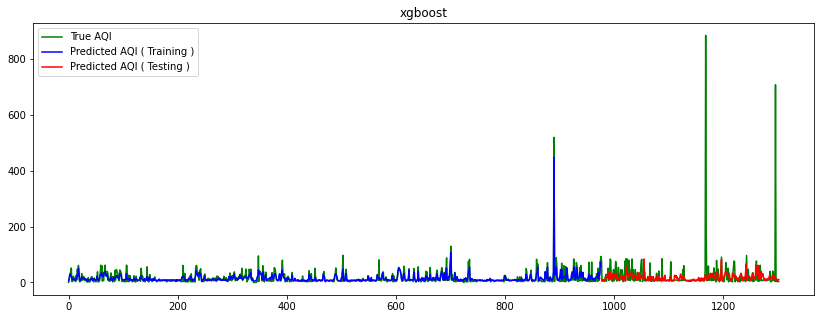

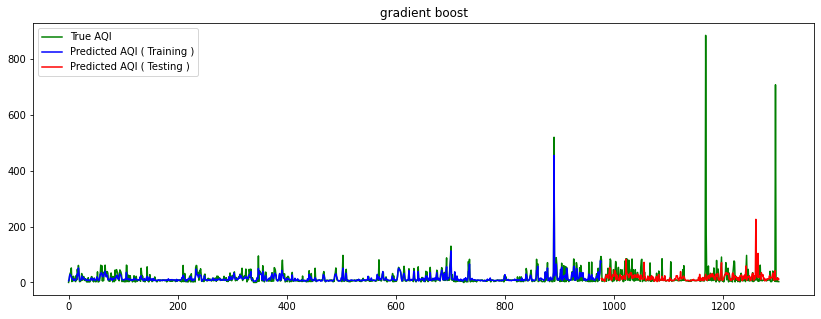

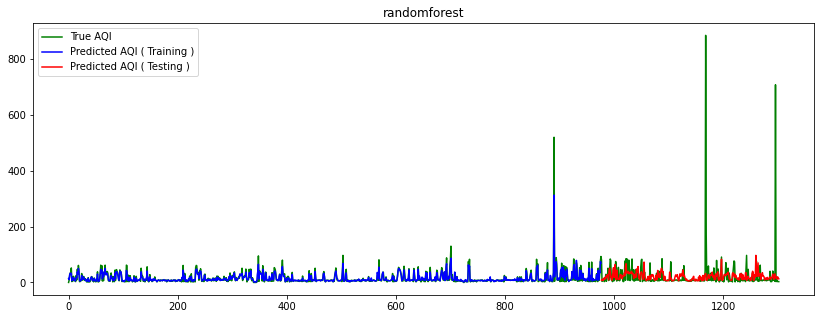

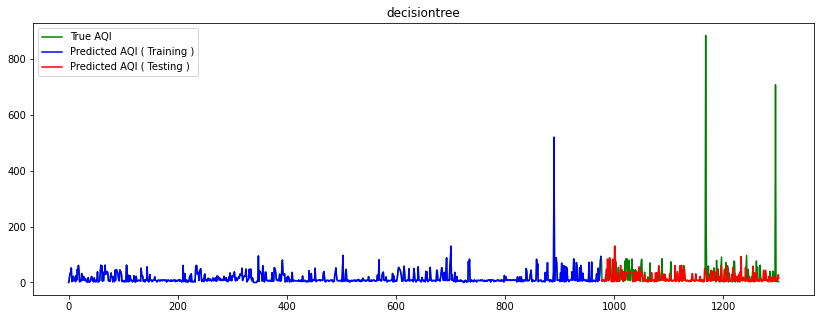

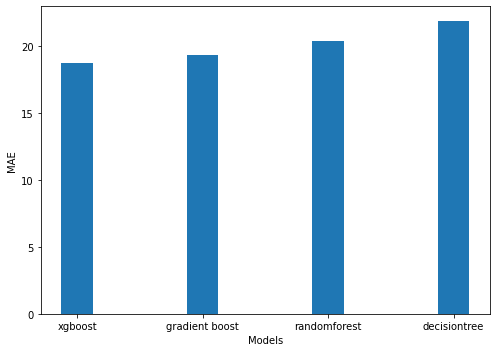

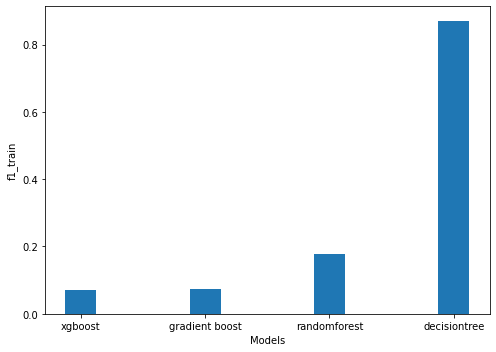

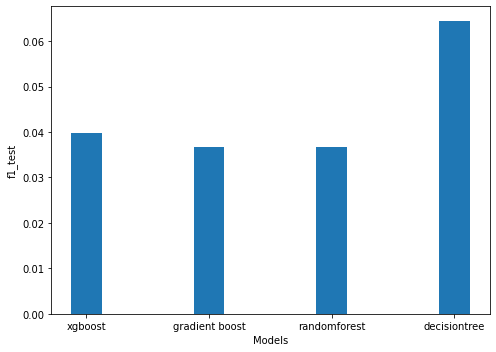

In [6]:
import xgboost
import numpy as np
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

X = train_data.drop(columns=['date']).fillna(0)
y = X.pop('aqi_next_day').values
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

model_1 = xgboost.XGBRegressor(random_state=42)
model_2 = GradientBoostingRegressor(random_state=42)
model_3 = RandomForestRegressor(random_state=42)
model_4 = DecisionTreeRegressor(random_state=42)
models = [model_1, model_2, model_3, model_4]

model_names = ['xgboost', 'gradient boost', 'randomforest', 'decisiontree']
f1_scores_train = []
f1_scores_test = []
maes = []

for model_i, model in enumerate(models):
  scX=StandardScaler()
  scy=StandardScaler()
  X_train_t = scX.fit_transform(X_train)
  y_train_t = scy.fit_transform(y_train.reshape(-1,1))
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,1)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,1)).squeeze().astype('int')
  # print(y_test)
  # print(test_preds)
  f1_scores_train.append(f1_score(y_train.astype('int'), train_preds,average='micro'))
  f1_scores_test.append(f1_score(y_test.astype('int'), test_preds,average='micro'))
  maes.append(mean_absolute_error(y_test, test_preds))

  test_preds_x = [t + len(train_preds) for t in range(len(test_preds))]
  fig = plt.figure(figsize=(14,5))
  plt.plot(y, label='True AQI', color='green')
  plt.plot(train_preds, label='Predicted AQI ( Training )', color='blue')
  plt.plot(test_preds_x, test_preds, label='Predicted AQI ( Testing )', color='red')
  plt.legend()
  plt.title(model_names[model_i])
  plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, f1_scores_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('f1_train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, f1_scores_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('f1_test')
plt.tight_layout()

    

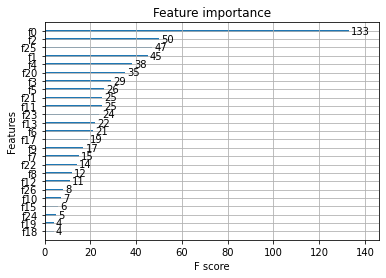

In [7]:
from xgboost import plot_importance

plot_importance(models[0])

In [18]:
X2 = train_data.drop(columns=['date', 'aqi_next_day']).fillna(0)
print(X2.columns)
# X2.drop(columns=[26,24,22,19,18,17,15,12,10,9,8,7])
X2.drop(X2.iloc[:, [26,24,22,19,18,17,15,12,10,9,8,7]],axis = 1, inplace=True)
print(X2.columns)

Index(['pm25', 'pm10', 'no2', 'so2', 'aqi', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk'],
      dtype='object')
Index(['pm25', 'pm10', 'no2', 'so2', 'aqi', 'tempmax', 'tempmin', 'dew',
       'precip', 'precipprob', 'preciptype', 'windspeed', 'winddir',
       'cloudcover', 'solarradiation', 'uvindex', 'severerisk'],
      dtype='object')


[12:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:23:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


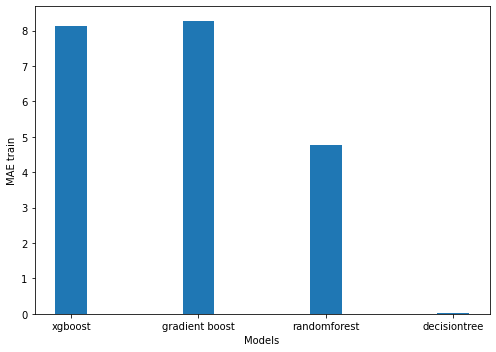

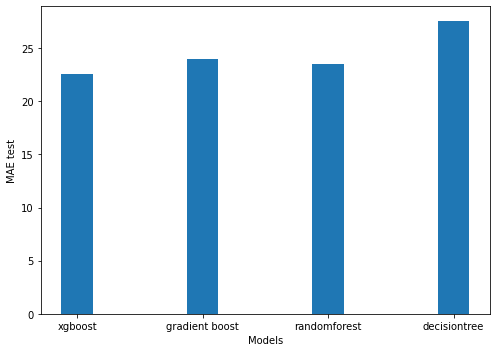

In [31]:
from sklearn.multioutput import RegressorChain

def daily_to_weekly(df):
    df_temp = pd.DataFrame()
    for column in df.columns:
      for i in range(1,8):
          df_temp[f'{column}_{i}'] = df[column].shift(-i)
        
    for i in range(1,8):
        df_temp[f'y_{i}'] = df['aqi'].shift(-7-i)
    df_temp = df_temp.dropna(axis=0)
    
    return df_temp
  
X3 = daily_to_weekly(X2)

y_cols = [col for col in X3.columns if col.startswith('y')]
y3 = X3[y_cols].values
X3.drop(columns=y_cols, inplace=True)
X3 = X3.values

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.15, random_state=42, shuffle=False)

model_1 = RegressorChain(xgboost.XGBRegressor(random_state=42))
model_2 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_3 = RandomForestRegressor(random_state=42)
model_4 = DecisionTreeRegressor(random_state=42)
models = [model_1, model_2, model_3, model_4]

model_names = ['xgboost', 'gradient boost', 'randomforest', 'decisiontree']
maes_train = []
maes_test = []

for model_i, model in enumerate(models):
  scX=StandardScaler()
  scy=StandardScaler()
  X_train_t = scX.fit_transform(X_train)
  y_train_t = scy.fit_transform(y_train.reshape(-1,7))
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,7)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
  maes_test.append(mean_absolute_error(y_test, test_preds))
  maes_train.append(mean_absolute_error(y_train, train_preds))

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE test')
plt.tight_layout()

[13:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[13:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[13:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[13:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


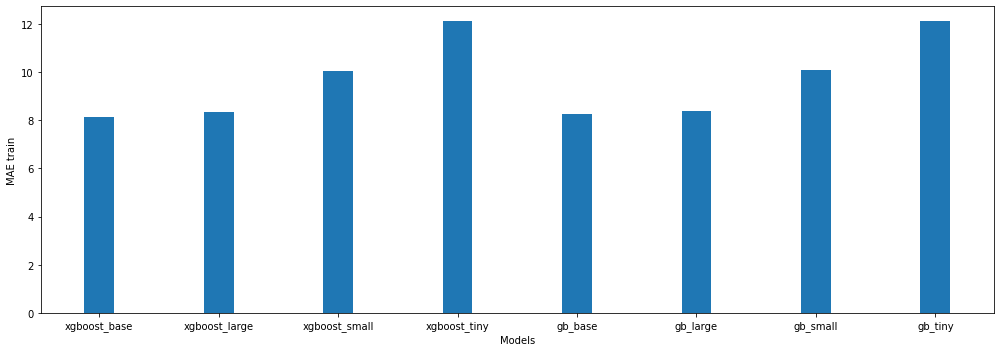

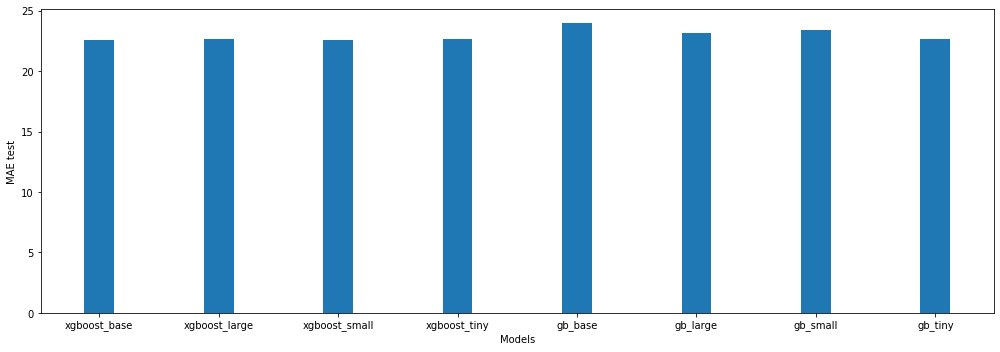

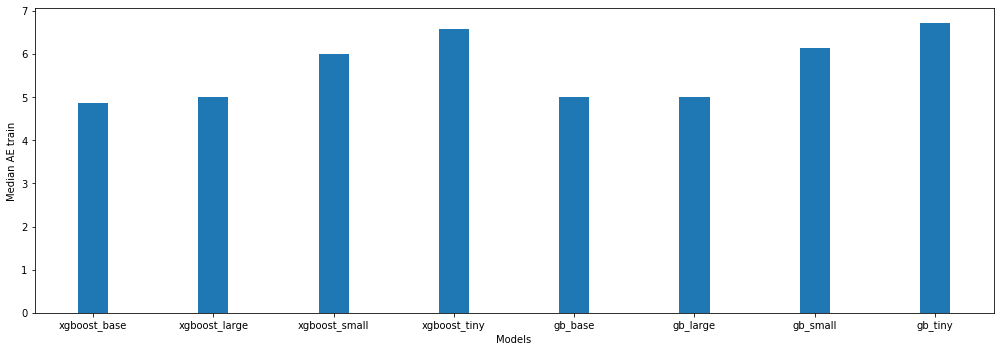

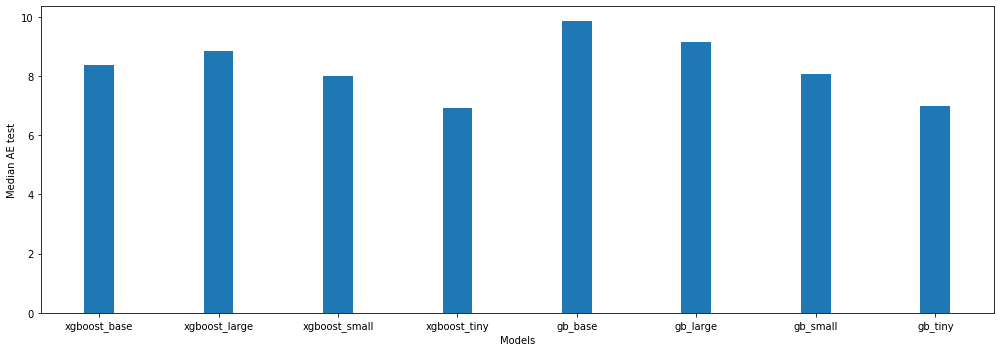

In [46]:
from sklearn.metrics import median_absolute_error

model_1 = RegressorChain(xgboost.XGBRegressor(random_state=42))
model_2 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=3, colsample_bytree=0.75, learning_rate=0.01, n_estimators=1000))
model_3 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=2))
model_4 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=1))
model_5 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_6 = RegressorChain(GradientBoostingRegressor(random_state=42, learning_rate=0.01, n_estimators=1000, max_depth=3))
model_7 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=2))
model_8 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=1))
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

model_names = ['xgboost_base', 'xgboost_large', 'xgboost_small', 'xgboost_tiny', 'gb_base', 'gb_large', 'gb_small', 'gb_tiny']
maes_train = []
maes_test = []
meaes_train = []
meaes_test = []

for model_i, model in enumerate(models):
  scX=StandardScaler()
  scy=StandardScaler()
  X_train_t = scX.fit_transform(X_train)
  y_train_t = scy.fit_transform(y_train.reshape(-1,7))
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,7)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
  maes_test.append(mean_absolute_error(y_test, test_preds))
  maes_train.append(mean_absolute_error(y_train, train_preds))
  meaes_test.append(median_absolute_error(y_test, test_preds))
  meaes_train.append(median_absolute_error(y_train, train_preds))

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, maes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, maes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE test')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, meaes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('Median AE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, meaes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('Median AE test')
plt.tight_layout()

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

mr = project.get_model_registry()

model_1 = RegressorChain(xgboost.XGBRegressor(random_state=42))
model_2 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=3, colsample_bytree=0.75, learning_rate=0.01, n_estimators=1000))
model_3 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=2))
model_4 = RegressorChain(xgboost.XGBRegressor(random_state=42, max_depth=1))
model_5 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_6 = RegressorChain(GradientBoostingRegressor(random_state=42, learning_rate=0.01, n_estimators=1000, max_depth=3))
model_7 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=2))
model_8 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=1))
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

model_names = ['xgboost_base', 'xgboost_large', 'xgboost_small', 'xgboost_tiny', 'gb_base', 'gb_large', 'gb_small', 'gb_tiny']

for model_i, model in enumerate(models):
    model_name = model_names[model_i]
    scX=StandardScaler()
    scy=StandardScaler()

    X_train_t = scX.fit_transform(X3)
    y_train_t = scy.fit_transform(y3.reshape(-1,7))
    model.fit(X_train_t, y_train_t)

    train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
    mae = mean_absolute_error(y3, train_preds)
    meae = median_absolute_error(y3, train_preds)

    input_schema = Schema(X_train_t)
    output_schema = Schema(y_train_t)
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

    joblib.dump(model, f'{model_name}.pkl')
    model = mr.python.create_model(
          name=model_name,
          metrics={"mean absolute error": mae, "median absolute error":meae},
          description=f"{model_name} : 7-day to 7-day air quality forecasting model, Reykjavík. Apply sklearn.standardscaler() before prediction",
          model_schema=model_schema
    )


In [56]:
#  !zip -r /content/xgboost_large.zip /content/xgboost_large.pkl
from google.colab import files

files.download('gb_large.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>